# Kernel Kaggle

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import gc
import time
import joblib
import imblearn
import sys
import os
import re
from datetime import datetime
import lime
import lime.lime_tabular

from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, roc_auc_score, roc_curve,make_scorer, accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

import lightgbm as lgb

import mlflow
import mlflow.sklearn

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from fonctions import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Attention veuillez modifier le chemin d'accès aux fichiers kaggle pour pouvoir utiliser le code :

In [2]:
path = 'C:/Users/sarah/Desktop/scoring/'

In [3]:
### Fonction qui permet de traiter le fichier application_train.csv ###

def application_train(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv(path+'application_train.csv', nrows= num_rows)
    test_df = pd.read_csv(path+'application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

### Fonction qui permet de traiter les fichiers Preprocess bureau.csv and bureau_balance.csv ###

def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv(path+'bureau.csv', nrows = num_rows)
    bb = pd.read_csv(path+'bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

### Fonction qui permet de traiter le fichier previous_applications.csv ###

def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv(path+'previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

### Fonction qui permet de traiter le fichier POS_CASH_balance.csv ###

def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv(path+'POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg


### Fonction qui permet de traiter le fichier installments_payments.csv ###

def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv(path+'installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

### Fonction qui permet de traiter le fichier credit_card_balance.csv ###

def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv(path+'credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [6]:
## Jointure des dataframes
df = application_train()
bureau = bureau_and_balance()
print("Bureau df shape:", bureau.shape)
df = df.join(bureau, how="left", on="SK_ID_CURR")
del bureau
gc.collect()
    
prev = previous_applications()
print("Previous applications df shape:", prev.shape)
df = df.join(prev, how="left", on="SK_ID_CURR")
del prev
gc.collect()
    
pos = pos_cash()
print("Pos-cash balance df shape:", pos.shape)
df = df.join(pos, how="left", on="SK_ID_CURR")
del pos
gc.collect()
    
ins = installments_payments()
print("Installments payments df shape:", ins.shape)
df = df.join(ins, how="left", on="SK_ID_CURR")
del ins
gc.collect()

cc = credit_card_balance()
print("Credit card balance df shape:", cc.shape)
df = df.join(cc, how="left", on="SK_ID_CURR")
del cc
gc.collect()

df = df.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
print('Enregistrement de df en data.csv')
df.to_csv( path+"data.csv")    

Train samples: 307511, test samples: 48744


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [4]:
# Ouverture du fichier
df = pd.read_csv("data.csv",index_col=[0])

# Analyse exploratoire de df_trainindex_col=

In [2]:
df_train = pd.read_csv('df_train_final.csv',index_col=[0])

In [6]:
df_train['TARGET'].value_counts()

0.0    46049
1.0     3951
Name: TARGET, dtype: int64

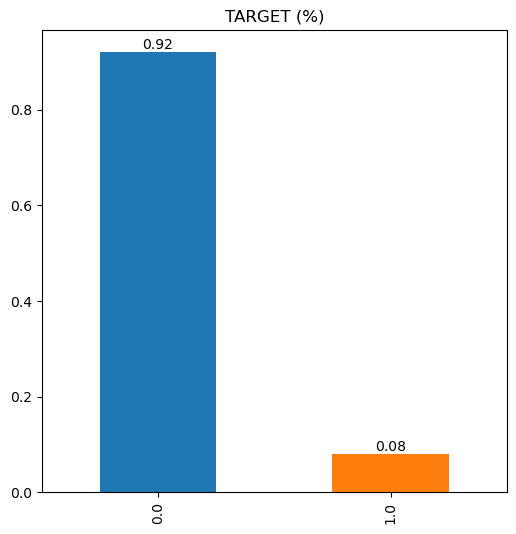

In [7]:
plt.figure(figsize=(6, 6))
ax0 =round(df['TARGET'].value_counts(normalize=True),2).plot(kind='bar', color=['#1f77b4', '#ff7f0e'])
ax0.bar_label(ax0.containers[0])
plt.title('TARGET (%)')
plt.show()

On constate un déséquilibre important de nos Target qu'il va falloir prendre en compte dans l'élaboration du modèle.  
Je vais paramétrer ma fonction de preprocessing afin qu'elle permette à l'utilisateur de choisir le mode de sampling :
* UnderSampling : réduction du nombre d'observations majoritaire
* OverSampling : consiste à dupliquer au hasard des exemples de la classe minoritaire et à les ajouter à l'ensemble de données d'apprentissage
* None : pas de sampling


# Préparation des données pour tester les modèles

suppression des colonnes à valeur unique
Suppression des colonnes qui contiennent plus de 75% de valeurs manquantes
Séparation df_train / df_test
0.0    282682
1.0     24825
Name: TARGET, dtype: int64
Imputation des valeurs manquantes
Valeurs manquantes avant traitement :  index                               0.000000
SK_ID_CURR                          0.000000
TARGET                              0.000000
CODE_GENDER                         0.000000
FLAG_OWN_CAR                        0.000000
                                      ...   
CC_NAME_CONTRACT_STATUS_nan_MAX     0.717389
CC_NAME_CONTRACT_STATUS_nan_MEAN    0.717389
CC_NAME_CONTRACT_STATUS_nan_SUM     0.717389
CC_NAME_CONTRACT_STATUS_nan_VAR     0.719444
CC_COUNT                            0.717389
Length: 763, dtype: float64


C:\Users\sarah\Desktop\scoring\fonctions.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace([np.inf, -np.inf], np.nan, inplace=True)


df shape : (307507, 763)
Valeurs manquantes après traitement :  index                               0.0
SK_ID_CURR                          0.0
TARGET                              0.0
CODE_GENDER                         0.0
FLAG_OWN_CAR                        0.0
                                   ... 
CC_NAME_CONTRACT_STATUS_nan_MAX     0.0
CC_NAME_CONTRACT_STATUS_nan_MEAN    0.0
CC_NAME_CONTRACT_STATUS_nan_SUM     0.0
CC_NAME_CONTRACT_STATUS_nan_VAR     0.0
CC_COUNT                            0.0
Length: 763, dtype: float64
(307507, 763)
Valeurs manquantes avant traitement :  index                               0.000000
SK_ID_CURR                          0.000000
TARGET                              1.000000
CODE_GENDER                         0.000000
FLAG_OWN_CAR                        0.000000
                                      ...   
CC_NAME_CONTRACT_STATUS_nan_MAX     0.658358
CC_NAME_CONTRACT_STATUS_nan_MEAN    0.658358
CC_NAME_CONTRACT_STATUS_nan_SUM     0.658358
CC_NAME_CO

C:\Users\sarah\Desktop\scoring\fonctions.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace([np.inf, -np.inf], np.nan, inplace=True)


df shape : (48744, 763)
Valeurs manquantes après traitement :  index                               0.0
SK_ID_CURR                          0.0
TARGET                              1.0
CODE_GENDER                         0.0
FLAG_OWN_CAR                        0.0
                                   ... 
CC_NAME_CONTRACT_STATUS_nan_MAX     0.0
CC_NAME_CONTRACT_STATUS_nan_MEAN    0.0
CC_NAME_CONTRACT_STATUS_nan_SUM     0.0
CC_NAME_CONTRACT_STATUS_nan_VAR     0.0
CC_COUNT                            0.0
Length: 763, dtype: float64
(48744, 763)
Sampling de df_train


C:\Users\sarah\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 14  89 276 281 289 293 297 306 395 403 406 432 437 442 452 465 480 494
 500 504 513 525 531 619 709 714 724 725 726 727 728 734 739 744 754 755
 756 757 758] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\sarah\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Train_test_split
Normalisation des données avec StandardScaler()
Application de la technique de sampling choisie : None
Pas de méthode sélectionnée


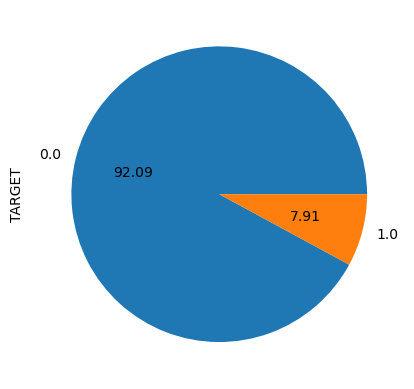

In [5]:
# Séparation du fichier en jeu d'entrainement et de test
X_train, X_test, y_train, y_test, x_col = preprocessing(df,standardiser=StandardScaler(),mode=None)

Création dun modèle 
Entrainement du modèle sur X_train / y_train
Optimisation du seuil de classification pour maximiser l'AUC
Seuil optimisé : 0.1
Scores du modèle avant optimisation
{'accuracy': 0.6852, 'f1_score': 0.23069403714565007, 'precision': 0.14277071990320628, 'recall': 0.6005089058524173, 'auc': 0.6929924923407295, 'cost': 28654}
Affichage des features importances avant optimisation


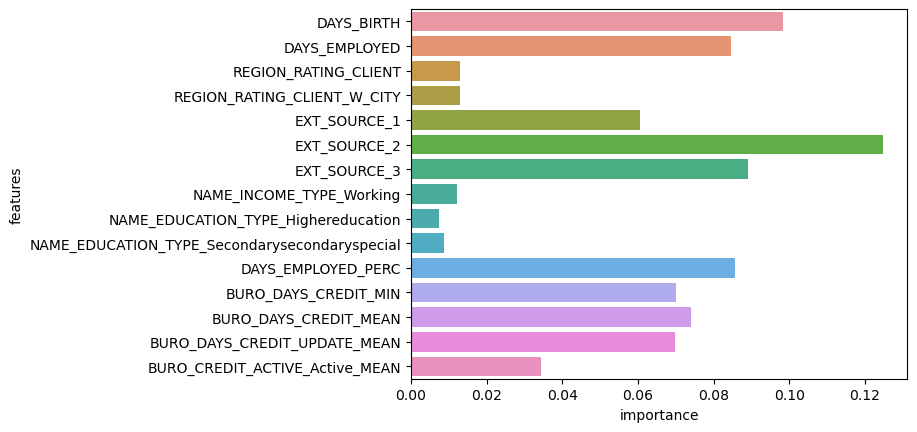

None
Affichage de la courbe Roc avant optimisation


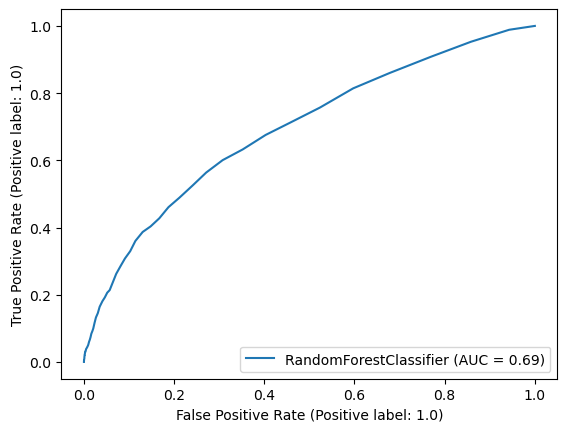

None
Affichage du rapport de classification avant optimisation
              precision  recall  f1-score   support
0.0                0.95    0.69      0.80   9214.00
1.0                0.14    0.60      0.23    786.00
accuracy           0.69    0.69      0.69      0.69
macro avg          0.55    0.65      0.52  10000.00
weighted avg       0.89    0.69      0.76  10000.00
None
Affichage de la matrice de confusion avant optimisation


<Figure size 640x480 with 0 Axes>

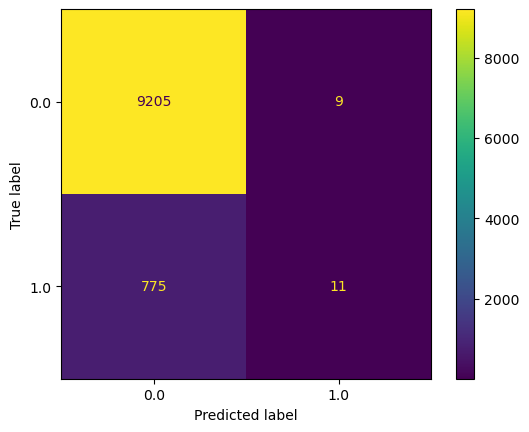

None
Création d'un dictionnaire pour optimiser les paramètres
Création d'un dictionnaire de scoring
Execution de GridSearchCV sur le modèle
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END class_weight=balanced, max_depth=13, n_estimators=255; total time=  12.0s
[CV] END class_weight=balanced, max_depth=13, n_estimators=255; total time=  12.0s
[CV] END class_weight=balanced, max_depth=13, n_estimators=255; total time=  13.4s
[CV] END class_weight=balanced, max_depth=13, n_estimators=255; total time=  12.3s
[CV] END class_weight=balanced, max_depth=13, n_estimators=255; total time=  12.0s
[CV] END class_weight=balanced, max_depth=13, n_estimators=260; total time=  12.4s
[CV] END class_weight=balanced, max_depth=13, n_estimators=260; total time=  12.5s
[CV] END class_weight=balanced, max_depth=13, n_estimators=260; total time=  12.3s
[CV] END class_weight=balanced, max_depth=13, n_estimators=260; total time=  12.3s
[CV] END class_weight=balanced, max_depth=13, n_estim

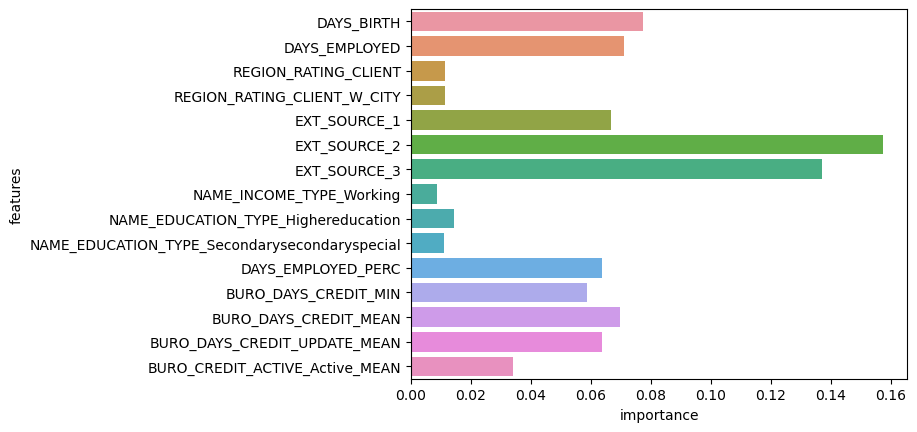

None
Affichage de la courbe Roc après optimisation


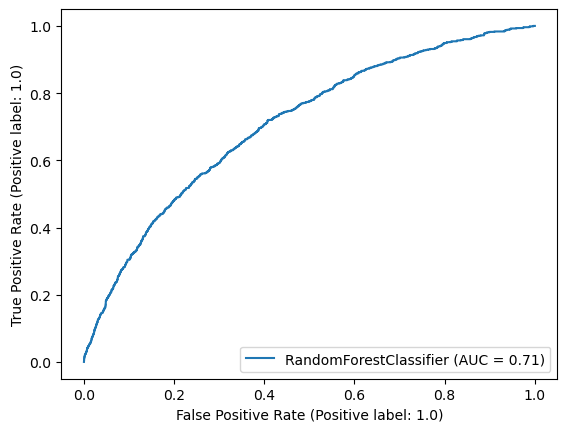

None
Affichage du rapport de classification après optimisation
              precision  recall  f1-score  support
0.0                0.96    0.59      0.73   9214.0
1.0                0.13    0.72      0.22    786.0
accuracy           0.60    0.60      0.60      0.6
macro avg          0.55    0.66      0.48  10000.0
weighted avg       0.90    0.60      0.69  10000.0
None
Affichage de la matrice de confusion après optimisation


<Figure size 640x480 with 0 Axes>

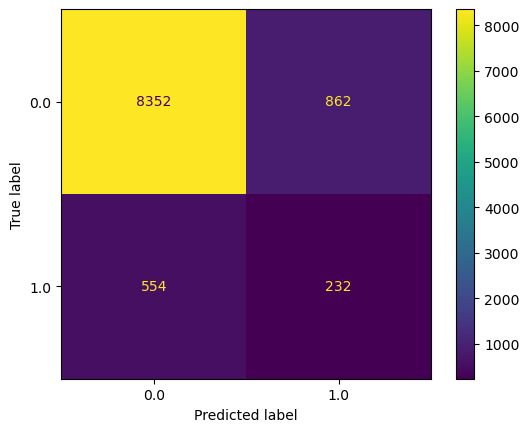

None


In [14]:
y_pred_optimal, y_proba, rf_model, y_pred_optimal_best, y_proba_best, best_rf_model,results_rf, df_result_rf = random_forest(X_train,y_train,X_test,y_test)

In [21]:
df_result_rf

,Modèle,Best accuracy,Best recall,Best cost,Best precision Score,Best auc score
0,Random forest,0.92989,0.980019,9005.2,0.89072,0.92989


Optimisation du seuil de classification pour maximiser l'AUC
Seuil optimisé : 1.0
Scores du modèle 
{'accuracy': 0.9214, 'f1_score': 0.0, 'precision': 0.0, 'recall': 0.0, 'auc': 0.5, 'cost': 786}
Affichage de la courbe Roc 


C:\Users\sarah\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sarah\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


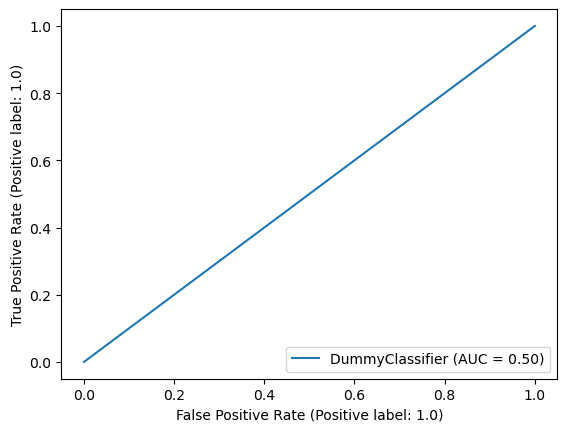

None
Affichage du rapport de classification 
              precision  recall  f1-score   support
0.0                0.92    1.00      0.96   9214.00
1.0                0.00    0.00      0.00    786.00
accuracy           0.92    0.92      0.92      0.92
macro avg          0.46    0.50      0.48  10000.00
weighted avg       0.85    0.92      0.88  10000.00
None
Affichage de la matrice de confusion


C:\Users\sarah\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sarah\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sarah\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

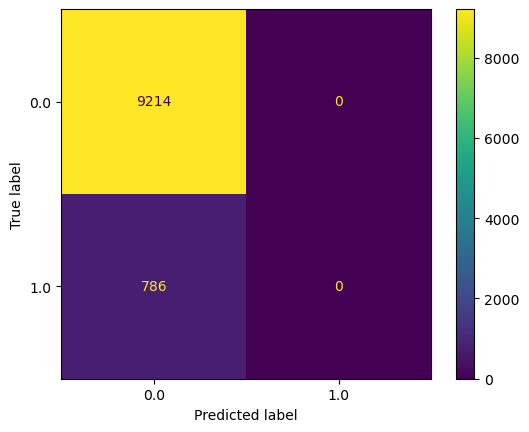

None


In [22]:
dummy_clf, y_pred_optimal_dummy,y_pred_proba_dummy,results_dummy = modele_dummy(X_train,y_train,X_test,y_test)

Création d'un modèle LGBM 
Entrainement du modèle sur X_train / y_train
Optimisation du seuil de classification pour maximiser l'AUC
Seuil optimisé : 0.06244329415898072
Scores du modèle avant optimisation
{'accuracy': 0.6124, 'f1_score': 0.2281959378733572, 'precision': 0.13526912181303116, 'recall': 0.7290076335877863, 'auc': 0.7246333436616809, 'cost': 36843}
Affichage des features importances avant optimisation


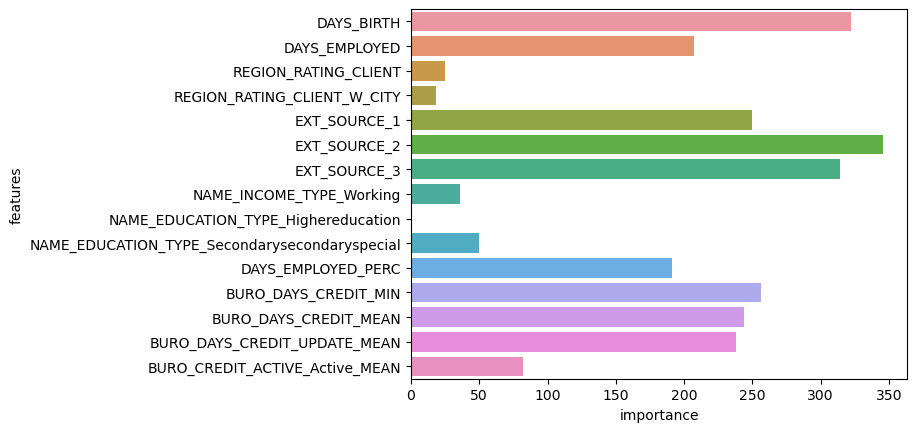

None
Affichage de la courbe Roc avant optimisation


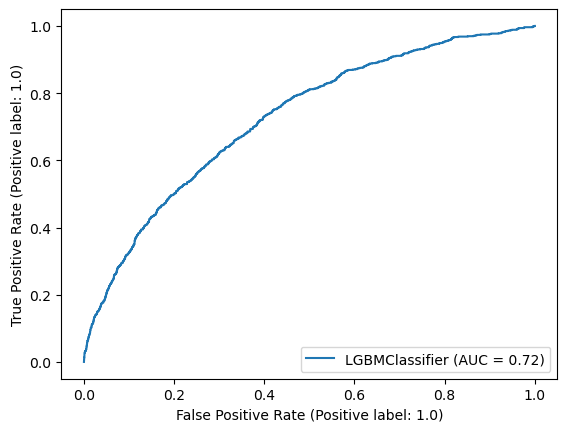

None
Affichage du rapport de classification avant optimisation
              precision  recall  f1-score   support
0.0                0.96    0.60      0.74   9214.00
1.0                0.14    0.73      0.23    786.00
accuracy           0.61    0.61      0.61      0.61
macro avg          0.55    0.67      0.48  10000.00
weighted avg       0.90    0.61      0.70  10000.00
None
Affichage de la matrice de confusion avant optimisation


<Figure size 640x480 with 0 Axes>

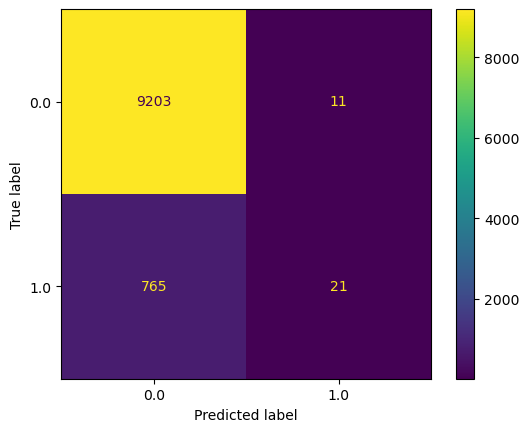

None
Création d'un dictionnaire pour optimiser les paramètres
Création d'un dictionnaire de scoring
Execution de GridSearchCV sur le modèle
Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END learning_rate=0.3, max_depth=8, n_estimators=260, num_leaves=40, scale_pos_weight=None; total time=   2.3s
[CV] END learning_rate=0.3, max_depth=8, n_estimators=260, num_leaves=40, scale_pos_weight=None; total time=   2.0s
[CV] END learning_rate=0.3, max_depth=8, n_estimators=260, num_leaves=40, scale_pos_weight=None; total time=   1.8s
[CV] END learning_rate=0.3, max_depth=8, n_estimators=260, num_leaves=40, scale_pos_weight=None; total time=   1.9s
[CV] END learning_rate=0.3, max_depth=8, n_estimators=260, num_leaves=40, scale_pos_weight=None; total time=   1.9s
[CV] END learning_rate=0.3, max_depth=8, n_estimators=260, num_leaves=40, scale_pos_weight=10; total time=   1.9s
[CV] END learning_rate=0.3, max_depth=8, n_estimators=260, num_leaves=40, scale_pos_weight=10; total ti

In [ ]:
y_pred_optimal, y_proba, lgb_model, y_pred_optimal_best, y_proba_best, best_lgb_model, results_lgb, df_result_lgb = lightgbm(X_train,y_train,X_test,y_test)

In [ ]:
best_lgb_model_explanation = explainer.explain_instance(X_test[1],
                                               best_lgb_model.predict_proba,
                                               num_features = 10
                                               )
best_lgb_model_explanation.show_in_notebook()


Création d'un modèle de régression logistique
Entrainement du modèle sur X_train / y_train
Optimisation du seuil de classification pour maximiser l'AUC
Seuil optimisé : 0.08833791797733724
Scores du modèle avant optimisation
{'accuracy': 0.7224, 'f1_score': 0.25134843581445526, 'precision': 0.1594798083504449, 'recall': 0.5928753180661578, 'auc': 0.7262939569225059, 'cost': 24880}
Affichage de la courbe Roc avant optimisation


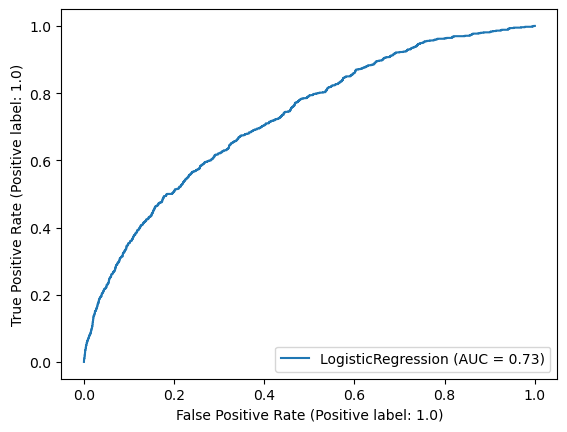

None
Affichage du rapport de classification avant optimisation
              precision  recall  f1-score   support
0.0                0.95    0.73      0.83   9214.00
1.0                0.16    0.59      0.25    786.00
accuracy           0.72    0.72      0.72      0.72
macro avg          0.56    0.66      0.54  10000.00
weighted avg       0.89    0.72      0.78  10000.00
None
Affichage de la matrice de confusion avant optimisation


<Figure size 640x480 with 0 Axes>

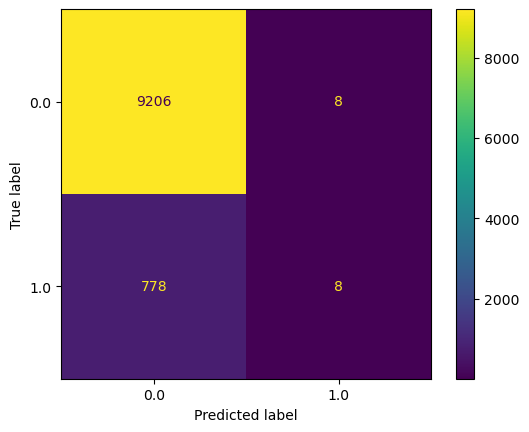

None
Création d'un dictionnaire pour optimiser les paramètres
Création d'un dictionnaire de scoring
Execution de GridSearchCV sur le modèle
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .........C=0.001, class_weight=balanced, penalty=l2; total time=   0.0s
[CV] END .........C=0.001, class_weight=balanced, penalty=l2; total time=   0.0s
[CV] END .........C=0.001, class_weight=balanced, penalty=l2; total time=   0.0s
[CV] END .........C=0.001, class_weight=balanced, penalty=l2; total time=   0.0s
[CV] END .........C=0.001, class_weight=balanced, penalty=l2; total time=   0.0s
[CV] END C=0.001, class_weight={0: 1.0859237138591014, 1: 12.638230647709321}, penalty=l2; total time=   0.0s
[CV] END C=0.001, class_weight={0: 1.0859237138591014, 1: 12.638230647709321}, penalty=l2; total time=   0.0s
[CV] END C=0.001, class_weight={0: 1.0859237138591014, 1: 12.638230647709321}, penalty=l2; total time=   0.0s
[CV] END C=0.001, class_weight={0: 1.0859237138591014, 1: 12.638

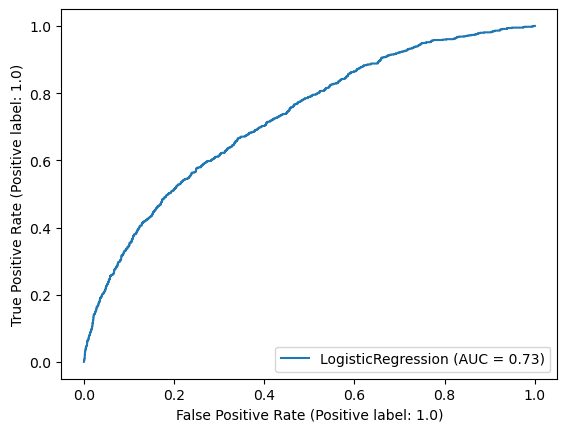

None
Affichage du rapport de classification après optimisation
              precision  recall  f1-score   support
0.0                0.95    0.75      0.84   9214.00
1.0                0.16    0.58      0.26    786.00
accuracy           0.74    0.74      0.74      0.74
macro avg          0.56    0.66      0.55  10000.00
weighted avg       0.89    0.74      0.79  10000.00
None
Affichage de la matrice de confusion après optimisation


<Figure size 640x480 with 0 Axes>

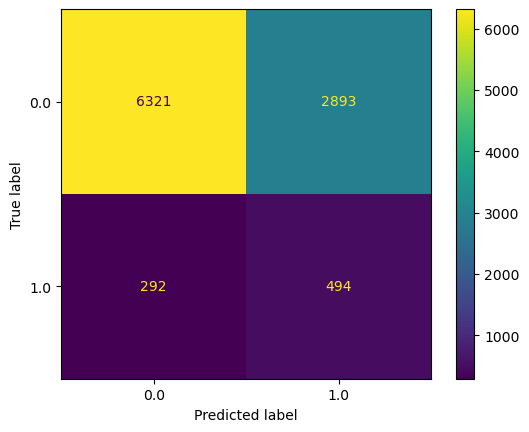

None


In [22]:
y_pred_optimal, y_proba, log_reg_model, y_pred_optimal_best, y_proba_best, best_log_reg_model, results_log_reg, df_result_log_reg = logistic_regression(X_train,y_train,X_test,y_test)

In [16]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_test,
                                                      mode = 'classification', 
                                                      feature_names = x_col,
                                                      class_names  = ['Refus', 'Accord'],
                                                      random_state = 42
                                                      )

In [23]:
explainer

In [24]:
best_log_reg_model_explanation = explainer.explain_instance(X_test[1],
                                               best_log_reg_model.predict_proba,
                                               num_features = 10
                                               )
best_log_reg_model_explanation.show_in_notebook()


# Partie ML FLOW

In [25]:
experiment_name = "baseline" 

In [26]:
create_experiment("baseline",results_dummy,dummy_clf,'confusion_matrix.png', 'roc_auc_curve.png','classification_report.txt','feature_importance.png',mode='oversampling')

Run - baseline_oversampling_15/03/2023 15:53:17_oversampling is logged to Experiment - baseline


# Partie ML FLOW

In [27]:
experiment_name = "Random_forest" 
run_metrics = results_rf

In [28]:
create_experiment("Random_forest" ,results_rf,best_rf_model,'confusion_matrix.png', 'roc_auc_curve.png','classification_report.txt','feature_importance.png',run_params=None,mode='oversampling')

Run - Random_forest_oversampling_15/03/2023 15:53:21_oversampling is logged to Experiment - Random_forest


In [29]:
experiment_name = "LGB" 
run_metrics = results_lgb

In [30]:
create_experiment("LGB" ,results_lgb,best_lgb_model,'confusion_matrix.png', 'roc_auc_curve.png','classification_report.txt','feature_importance.png',run_params=None,mode='oversampling')

Run - LGB_oversampling_15/03/2023 15:53:25_oversampling is logged to Experiment - LGB


In [31]:
experiment_name = "Log_reg" 
run_metrics = results_log_reg

In [32]:
create_experiment("Log_reg" ,results_log_reg,best_log_reg_model,'confusion_matrix.png', 'roc_auc_curve.png','classification_report.txt','feature_importance.png',run_params=None,mode='oversampling')

Run - Log_reg_oversampling_15/03/2023 15:53:29_oversampling is logged to Experiment - Log_reg


# Enregistrement du modèle

In [20]:
import pickle

# Enregistrer le modèle dans un fichier
filename = 'best_lgb_model.pkl'
pickle.dump(best_lgb_model, open(filename, 'wb'))

# Enregistrement de l'explainer de Lime
pickle.dump(lgb_explainer, open('Lgb_explainer.sav', 'wb'))

In [22]:
# Enregistrer le modèle dans un fichier
filename = 'best_log_reg_model.pkl'
pickle.dump(best_log_reg_model, open(filename, 'wb'))

# Enregistrement de l'explainer de Lime
pickle.dump(log_reg_explainer, open('Log_reg_explainer.sav', 'wb'))

In [ ]:
# Preprocessing du fichier pour le tableau de bord

In [ ]:
df_test = pd.read_csv('df_test_final.csv')
df_test = df_test.rename(columns={'Unnamed: 0':'SK_ID_CURR'})

In [ ]:
df_test.sort_values('SK_ID_CURR')

In [ ]:
df_visu = pd.read_csv('application_test.csv')

In [ ]:
df_visu

In [ ]:
liste_client = df_test['SK_ID_CURR'].unique()

In [ ]:
df_visu = df_visu.loc[df_visu['SK_ID_CURR'].isin(liste_client)][['SK_ID_CURR','NAME_CONTRACT_TYPE','DAYS_BIRTH','NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'CNT_CHILDREN']]

In [ ]:
df_visu

In [ ]:
df_visu.to_csv('df_test_final_visu.csv')

In [ ]:
df_dash_train = pd.read_csv('application_train.csv')

In [ ]:
df_dash_train

In [ ]:
df_dash_train = df_dash_train.sample(n=500, replace=False, random_state=1)

In [ ]:
df_dash_train

In [ ]:
liste_col_categ = ['SK_ID_CURR','NAME_INCOME_TYPE_Working',
                                 'NAME_EDUCATION_TYPE_Highereducation','NAME_EDUCATION_TYPE_Secondarysecondaryspecial']

In [ ]:
liste_col_categ

In [ ]:
df_dash_categ = df_dash_categ.loc[:,liste_col_categ]

In [ ]:
df_dash

In [ ]:
df_dash = nan_value(df_dash)

In [ ]:
df_dash.to_csv('df_dash.csv')